In [1]:
# data munging and visualization
import numpy as np
import pandas as pd
import itertools

# class imbalance treatment
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# feature engineering (featuretools)
import featuretools as ft
from featuretools.selection import remove_low_information_features
from featuretools import variable_types as vtypes

# feature engineering (tsfresh)
from tsfresh import extract_features
from tsfresh import select_features

# predictor -> classification, regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier

# miscellanous
import datetime
import os

# external functions
import utils

# parallelization
from dask import bag
from dask.diagnostics import ProgressBar

/home/jo/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/jo/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pbar = ProgressBar()
pbar.register()

## Iteration 1 (Unparallelized, find top features)

In [3]:
seriousbuxers_only = False

### Cohort entity

#### Vix features

In [4]:
cohorts = pd.read_csv("data/cohorts.csv")
# cohorts['year-month'] = pd.to_datetime(cohorts['year-month'])
cohorts.reset_index(inplace=True)
cohorts.rename(columns={'index': 'cohort_id'}, inplace=True)
cohorts.head()

,cohort_id,report_week,Commodity,Currency,Future,Index,Stock,Currency_norm,Future_norm,Index_norm,Stock_norm
0,0,2016-10-03,121.670178,105.126720,55.977572,71.856906,81.741464,1.118369,0.666400,0.845375,0.888494
1,1,2016-10-10,76.958261,97.906805,64.388402,76.701221,81.688184,1.041562,0.766529,0.902367,0.887915
2,2,2016-10-17,60.807821,82.015868,51.020668,58.416466,75.005426,0.872509,0.607389,0.687253,0.815276
3,3,2016-10-24,74.638628,79.819829,61.388038,66.075777,84.903987,0.849147,0.730810,0.777362,0.922869
4,4,2016-10-31,86.643977,85.911707,74.717124,77.367756,90.401676,0.913954,0.889490,0.910209,0.982627


#### Cohort values

In [5]:
cohort_wow_values = pd.read_csv('data/cohort_wow_values.csv')
cohort_wow_values.head()

,report_week,cohort_value
0,2016-09-26,7910.58
1,2016-10-03,26015.06
2,2016-10-10,78783.53
3,2016-10-17,20273.10
4,2016-10-24,32364.92


In [6]:
cohort_ts = pd.read_csv('data/cohort_ts.csv')
cohort_ts = cohort_ts[~pd.isnull(cohort_ts['product_type'])]
cohort_ts.head()

,report_week,date,product_type,price
0,2016-09-26,2016-10-01 00:00:00,Stock,0.015
1,2016-09-26,2016-10-01 01:00:00,Stock,0.015
2,2016-09-26,2016-10-01 02:00:00,Stock,0.015
3,2016-09-26,2016-10-01 03:00:00,Stock,0.015
4,2016-09-26,2016-10-01 04:00:00,Stock,0.015


In [7]:
# https://www.youtube.com/watch?v=Fm8zcOMJ-9E

# extract the features
cohort_feature_matrix = extract_features(cohort_ts[['report_week', 'price', 'product_type']], column_id="report_week", column_sort='product_type')

# merge the feature matrix with the target values (cohort values)
cohort_feature_matrix = pd.merge(cohort_feature_matrix.reset_index(), cohort_wow_values, left_on='id', right_on='report_week')
# extract the target values
y = cohort_feature_matrix['cohort_value']
cohort_feature_matrix.drop(['cohort_value', 'report_week'], axis=1, inplace=True)
cohort_feature_matrix = cohort_feature_matrix.fillna(0)

Feature Extraction: 100%|██████████| 9/9 [02:22<00:00, 15.81s/it]


In [74]:
selected_feature_matrix = select_features(cohort_feature_matrix, y, fdr_level=0.9)

In [75]:
selected_feature_matrix['report_week'] = cohort_feature_matrix['id']
print(len(cohort_feature_matrix.columns), len(selected_feature_matrix.columns))
selected_feature_matrix.head()

795 10


,price__energy_ratio_by_chunks__num_segments_10__segment_focus_2,"price__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0","price__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.0","price__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.0",price__median,price__quantile__q_0.4,"price__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0",price__energy_ratio_by_chunks__num_segments_10__segment_focus_3,price__partial_autocorrelation__lag_7,report_week
0,8.976867e-12,0.000000,0.000000,0.000000,0.0150,0.015,0.000000,8.976867e-12,0.174637,2016-09-26
1,4.541530e-06,3.645182,3.660578,0.178122,50.2400,48.610,29.520081,1.414559e-05,0.028937,2016-10-03
2,4.481428e-06,0.003460,0.004125,0.025798,51.1550,50.108,27.017432,1.486707e-05,0.002910,2016-10-10
3,4.426371e-06,0.001233,0.001523,0.017030,51.1975,50.399,24.950728,1.510143e-05,-0.006612,2016-10-17
4,4.235501e-06,6.061913,6.136163,0.299022,50.4650,49.260,22.363594,1.338881e-05,0.032522,2016-10-24


#### Merging vix and customer features

In [76]:
cohorts = pd.merge(cohorts, selected_feature_matrix, on='report_week')
cohorts.head()

,cohort_id,report_week,Commodity,Currency,Future,Index,Stock,Currency_norm,Future_norm,Index_norm,Stock_norm,price__energy_ratio_by_chunks__num_segments_10__segment_focus_2,"price__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0","price__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.0","price__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.0",price__median,price__quantile__q_0.4,"price__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0",price__energy_ratio_by_chunks__num_segments_10__segment_focus_3,price__partial_autocorrelation__lag_7
0,0,2016-10-03,121.670178,105.126720,55.977572,71.856906,81.741464,1.118369,0.666400,0.845375,0.888494,0.000005,3.645182,3.660578,0.178122,50.2400,48.610,29.520081,0.000014,0.028937
1,1,2016-10-10,76.958261,97.906805,64.388402,76.701221,81.688184,1.041562,0.766529,0.902367,0.887915,0.000004,0.003460,0.004125,0.025798,51.1550,50.108,27.017432,0.000015,0.002910
2,2,2016-10-17,60.807821,82.015868,51.020668,58.416466,75.005426,0.872509,0.607389,0.687253,0.815276,0.000004,0.001233,0.001523,0.017030,51.1975,50.399,24.950728,0.000015,-0.006612
3,3,2016-10-24,74.638628,79.819829,61.388038,66.075777,84.903987,0.849147,0.730810,0.777362,0.922869,0.000004,6.061913,6.136163,0.299022,50.4650,49.260,22.363594,0.000013,0.032522
4,4,2016-10-31,86.643977,85.911707,74.717124,77.367756,90.401676,0.913954,0.889490,0.910209,0.982627,0.000004,1.423346,1.426446,0.100509,46.9650,44.762,26.234043,0.000013,-0.076524


### Users entity

In [8]:
# sample_user_ratio = 20
user_details = pd.read_csv("data/users_1y_6mCustomerValue_3000.csv")
user_details['bux_account_created_dts'] = pd.to_datetime(user_details['bux_account_created_dts']) # format="%m/%d/%y %H:%M")
# user_details['month_year'] = user_details['bux_account_created_dts'].apply(lambda x: x.strftime('%B-%Y'))
# user_details['year-week'] = user_details['bux_account_created_dts'].dt.strftime('%Y-%U')
user_details.reset_index(drop=True,inplace=True)
user_details = user_details[user_details.columns[1:]]

user_details.reset_index(drop=True,inplace=True)
user_details = pd.merge(user_details, cohorts[['cohort_id', 'report_week']], on='report_week')
distinct_users = user_details["user_id"].unique()
user_details.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,ams_first_funded_dts,initial_deposit_amount,trading_segment,report_week,cohort_id
0,003bfd2c-8ae8-473c-93ec-1b5729f8609f,DE,NaN,NaN,iOS,SOME,Experienced Trader,Organic,2017-01-03 18:13:22.059,NaN,NaN,No Trades,2017-01-02,13
1,04172593-c46d-48d4-9c65-eb34cfd06253,DE,MALE,DE,iOS,NONE,Rookie Trader,Facebook Installs,2017-01-05 19:01:07.442,NaN,NaN,Mix Trader,2017-01-02,13
2,13eb31dc-2c43-41c4-8aad-cd4871cb22b4,AT,NaN,NaN,iOS,SOME,Experienced Trader,Viral Invites,2017-01-05 17:16:51.298,NaN,NaN,ICC Trader,2017-01-02,13
3,1485f1a1-1918-4b98-8970-40aa70f2a8aa,DE,NaN,NaN,iOS,SOME,Experienced Trader,Facebook Installs,2017-01-03 18:10:56.026,NaN,NaN,No Trades,2017-01-02,13
4,180b5130-c6a1-458d-9800-38ed75fea33f,SE,NaN,NaN,iOS,NONE,Rookie Trader,Instagram Installs,2017-01-06 20:24:10.417,NaN,NaN,No Trades,2017-01-02,13


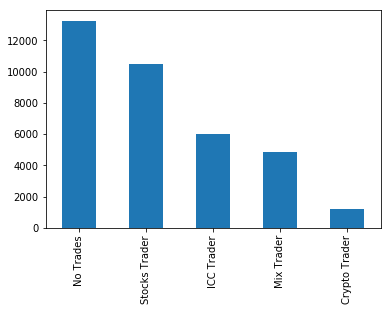

In [9]:
user_details['trading_segment'].value_counts().plot(kind='bar');

In [10]:
len(distinct_users)

35741

## Transactions entity

In [11]:
# # transactions entity
daily_transactions = transactions = pd.read_csv('data/cube_1y_6mCustomerValue_3000.csv')
daily_transactions['date'] = pd.to_datetime(daily_transactions['date']) # , format="%m/%d/%y %H:%M")
daily_transactions = daily_transactions[daily_transactions.columns[1:]]
daily_transactions.reset_index(inplace=True,drop=True)
daily_transactions.reset_index(inplace=True)
daily_transactions.rename(columns={'index': 'transaction_id'}, inplace=True)
daily_transactions.head()

/home/jo/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,transaction_id,user_id,date,trades_sb_invested_amount,financing_deposits_amount,trades_sb_short,trades_sb_long,view_position,trades_sb_open_positions,total_session_duration,education_topic_read,trades_fb_commission,trades_fb_forex_open,trades_sb_forex_open,conversion_to_sb,trades_fb_stocks_average_leverage,trades_sb_stocks_average_leverage,trades_sb_forex_average_leverage
0,0,d4103d44-ce8b-4a72-83ce-b1f2ddef9bbe,2016-11-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,1,d5374826-adaf-4ad6-bfa3-14a0ebda1718,2016-11-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,2,d7e7fea9-d016-4708-aeeb-876bfbfb5ac3,2016-11-23,0.0,0.0,0.0,0.0,2.0,0.0,30.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,3,db375d5a-15b2-4871-9c07-af54e78bbbc6,2016-11-23,0.0,0.0,0.0,0.0,6.0,0.0,158.0,0.0,0.48,0.0,0.0,0.0,2.0,0.0,0.0
4,4,dc11be65-1bcd-43cb-9195-4cfd0dde5cb4,2016-11-23,0.0,0.0,0.0,0.0,5.0,0.0,116.0,0.0,1.75,0.0,0.0,0.0,5.0,0.0,0.0


In [12]:
user_conversion = pd.DataFrame(daily_transactions.fillna(0).groupby('user_id')['conversion_to_sb'].max()).reset_index()
user_conversion.head()

,user_id,conversion_to_sb
0,0,0.0
1,00003ad5-d62d-4a88-ae32-558b9ac70915,0.0
2,00031f8f-1fa4-4890-9799-e2cb532fdef3,0.0
3,0006e8e4-d5db-4985-8d37-cdf64d4a72b9,0.0
4,0006fdaa-91ea-440d-b163-efe8d00e5910,0.0


In [13]:
len(daily_transactions['user_id'].unique()) == len(user_conversion)

True

In [14]:
# filter only converted users - daily_transactions, user_details

if seriousbuxers_only ==  True:
    converted_users = daily_transactions[daily_transactions['conversion_to_sb'] == 1]['user_id']
    daily_transactions = daily_transactions[daily_transactions['user_id'].isin(converted_users)]
    user_details = user_details[user_details['user_id'].isin(converted_users)]
len(daily_transactions['user_id'].unique())

35192

## Creating the entity set

In [15]:
es = ft.EntitySet("bux_cltv")


es.entity_from_dataframe(entity_id='cohorts',
                        dataframe=cohorts,
                        index='cohort_id')
                        
es.entity_from_dataframe(entity_id='users',
                    dataframe=user_details,
                    index='user_id',
                    time_index='bux_account_created_dts')

es.entity_from_dataframe(entity_id='transactions',
                    dataframe=daily_transactions,
                    index='transaction_id',
                    time_index='date')

# interesting values -> in transactions entity
# es['users']['trading_segment'].interesting_values = ['ICC Trader', 'Crypto Trader']
# example 1: "COUNT(sessions WHERE device = tablet)"
# example 2: "AVG_TIME_BETWEEN(sessions.session_start WHERE device = tablet)"

es.add_relationship(ft.Relationship(es['cohorts']['cohort_id'], es['users']['cohort_id']))
es.add_relationship(ft.Relationship(es['users']['user_id'], es['transactions']['user_id']))

Entityset: bux_cltv
  Entities:
    transactions (shape = [792000, 18])
    cohorts (shape = [52, 11])
    users (shape = [35741, 14])
  Relationships:
    users.cohort_id -> cohorts.cohort_id
    transactions.user_id -> users.user_id

### Target values (whale / not whale)

In [16]:
label_data = pd.read_csv('data/curcv_1y_6mCustomerValue_3000.csv')
label_data = label_data[label_data.columns[1:]]
label_data["label"] = label_data["com"] + label_data["ff"]
label_data = label_data[['user_id', 'label']]
label_data = label_data.fillna(0)

# whale_threshold = label_data["label"].quantile(0.99)
whale_threshold = 50
label_data["curcv"] = label_data["label"]
label_data["label"] = (label_data['curcv'] > whale_threshold).astype(int)
label_data['label'].value_counts()

0    35603
1      397
Name: label, dtype: int64

In [17]:
%%time
# Adding agg. primitives: Trend, Median & Skew -> Wall time: 1h 22min 57s (no improvement of performance)
# Adding trans. primitives: Day, Week, Month, Weekday, Weekend -> Wall time: 12min 58s (improvement of performance)
# Adding calendar data: 15 min (improvement of performance)

from featuretools.primitives import (Sum, Std, Max, Min, Mean,
                                 Count, PercentTrue, NUnique, 
                                 Day, Week, Month, Weekday, Weekend)


trans_primitives = [Day, Week, Month, Weekday, Weekend]
agg_primitives = [Sum, Std, Max, Min, Mean, Count, PercentTrue, NUnique]


variable_types = {
    'social_status': vtypes.Categorical, 
    'vendor_id': vtypes.Ordinal
}

feature_matrix, features = ft.dfs(
    entityset=es,
    target_entity="users",
    trans_primitives=trans_primitives,
    agg_primitives=agg_primitives,
    # variable_types=variable_types,
    #  where_primitives=["count", "avg_time_between"],
    max_depth=2,
    verbose=True
)

print("{} features generated".format(len(features)))

fm_encoded, features_encoded = ft.encode_features(feature_matrix, features)
fm_encoded = fm_encoded.fillna(0)
# fm_encoded = remove_low_information_features(fm_encoded)

Building features: 342it [00:00, 1331.73it/s]
Progress: 100%|██████████| 1/1 [15:39<00:00, 939.63s/cutoff time]
209 features generated
CPU times: user 15min 38s, sys: 7.91 s, total: 15min 46s
Wall time: 15min 50s


### Classification (Random Forest)

In [18]:
# drop after rerunning DFS again
X = fm_encoded.reset_index().merge(label_data)
X.drop(['user_id', 'curcv'], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop('label').astype('int')
y.value_counts()

0    35345
1      396
Name: label, dtype: int64

In [19]:
# number of features (with encoded features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
len(X.columns)

400

In [20]:
X.head()

,trading_segment = No Trades,trading_segment = Stocks Trader,trading_segment = ICC Trader,trading_segment = Mix Trader,trading_segment = Crypto Trader,trading_segment = unknown,trading_experience = NONE,trading_experience = SOME,trading_experience = EXPERT,trading_experience = FUN_BUX,...,cohorts.MAX(transactions.trades_sb_forex_average_leverage),cohorts.STD(transactions.trades_sb_stocks_average_leverage),cohorts.MIN(transactions.education_topic_read),cohorts.SUM(users.initial_deposit_amount),cohorts.MAX(transactions.education_topic_read),cohorts.MIN(transactions.trades_sb_short),cohorts.STD(transactions.conversion_to_sb),cohorts.COUNT(users),cohorts.MAX(transactions.conversion_to_sb),cohorts.MIN(transactions.trades_fb_forex_open)
0,0,0,1,0,0,0,0,1,0,0,...,30.0,0.624429,0.0,2500.0,27.0,0.0,0.079204,599,1.0,0.0
1,0,0,1,0,0,0,1,0,0,0,...,30.0,0.490385,0.0,2900.0,37.0,0.0,0.072111,749,1.0,0.0
2,0,0,1,0,0,0,1,0,0,0,...,30.0,0.551414,0.0,3550.0,48.0,0.0,0.061789,582,1.0,0.0
3,0,0,0,1,0,0,1,0,0,0,...,22.0,0.371907,0.0,2750.0,48.0,0.0,0.059802,665,1.0,0.0
4,0,0,1,0,0,0,1,0,0,0,...,30.0,0.441299,0.0,4050.0,46.0,0.0,0.066916,789,1.0,0.0


In [21]:
# cohorts.MAX(users.initial_deposit_amount)

In [22]:
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
# rf_clfrf_clf = RFE(rf_clf, 20, step=1)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

              Score
Fscore     0.576271
Precision  0.796875
Recall     0.451327


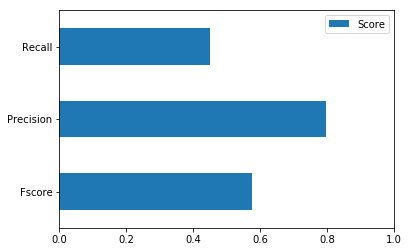

In [23]:
utils.evaluate_performance(y_pred, y_test)

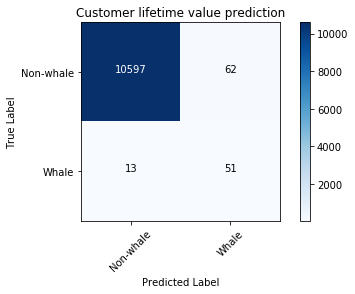

In [24]:
cm = confusion_matrix(y_pred, y_test)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [25]:
# random forest classifer, 5-fold cross-validation
# https://datascience.stackexchange.com/questions/6510/does-modeling-with-random-forests-requre-cross-validation
scores = cross_val_score(estimator=rf_clf, X=X, y=y, scoring='f1', verbose=True, cv=5, n_jobs=-1)
"F1 %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


'F1 0.55 +/- 0.03'

In [26]:
# 47: Feature: <Feature: cohorts.Commodity_vix>, 0.005
# 57: Feature: <Feature: cohorts.Currency_vix>, 0.004
# 61: Feature: <Feature: cohorts.MEAN(transactions.trades_sb_forex_open)>, 0.004
# 72: Feature: <Feature: cohorts.STD(transactions.education_topic_read)>, 0.004
# 89: Feature: <Feature: cohorts.MEAN(transactions.trades_sb_short)>, 0.003
utils.feature_importances(rf_clf, features_encoded, n=100)

1: Feature: <Feature: initial_deposit_amount>, 0.042
2: Feature: <Feature: WEEKDAY(ams_first_funded_dts) = unknown>, 0.033
3: Feature: <Feature: SUM(transactions.trades_sb_invested_amount)>, 0.028
4: Feature: <Feature: STD(transactions.trades_sb_invested_amount)>, 0.027
5: Feature: <Feature: MAX(transactions.trades_sb_invested_amount)>, 0.024
6: Feature: <Feature: SUM(transactions.financing_deposits_amount)>, 0.024
7: Feature: <Feature: MEAN(transactions.trades_sb_invested_amount)>, 0.023
8: Feature: <Feature: SUM(transactions.trades_sb_short)>, 0.019
9: Feature: <Feature: STD(transactions.financing_deposits_amount)>, 0.018
10: Feature: <Feature: MAX(transactions.financing_deposits_amount)>, 0.017
11: Feature: <Feature: MONTH(ams_first_funded_dts) = unknown>, 0.017
12: Feature: <Feature: STD(transactions.trades_sb_open_positions)>, 0.015
13: Feature: <Feature: SUM(transactions.total_session_duration)>, 0.014
14: Feature: <Feature: SUM(transactions.trades_sb_long)>, 0.014
15: Feature: <

[<Feature: initial_deposit_amount>,
 <Feature: WEEKDAY(ams_first_funded_dts) = unknown>,
 <Feature: SUM(transactions.trades_sb_invested_amount)>,
 <Feature: STD(transactions.trades_sb_invested_amount)>,
 <Feature: MAX(transactions.trades_sb_invested_amount)>,
 <Feature: SUM(transactions.financing_deposits_amount)>,
 <Feature: MEAN(transactions.trades_sb_invested_amount)>,
 <Feature: SUM(transactions.trades_sb_short)>,
 <Feature: STD(transactions.financing_deposits_amount)>,
 <Feature: MAX(transactions.financing_deposits_amount)>,
 <Feature: MONTH(ams_first_funded_dts) = unknown>,
 <Feature: STD(transactions.trades_sb_open_positions)>,
 <Feature: SUM(transactions.total_session_duration)>,
 <Feature: SUM(transactions.trades_sb_long)>,
 <Feature: SUM(transactions.view_position)>,
 <Feature: MEAN(transactions.trades_sb_short)>,
 <Feature: MEAN(transactions.view_position)>,
 <Feature: MEAN(transactions.financing_deposits_amount)>,
 <Feature: MAX(transactions.trades_sb_long)>,
 <Feature: SUM

In [27]:
# calculate the top 20 features based on feature importance
top_features = utils.feature_importances(rf_clf, features_encoded, n=20)
ft.save_features(top_features, "top_features")

1: Feature: <Feature: initial_deposit_amount>, 0.042
2: Feature: <Feature: WEEKDAY(ams_first_funded_dts) = unknown>, 0.033
3: Feature: <Feature: SUM(transactions.trades_sb_invested_amount)>, 0.028
4: Feature: <Feature: STD(transactions.trades_sb_invested_amount)>, 0.027
5: Feature: <Feature: MAX(transactions.trades_sb_invested_amount)>, 0.024
6: Feature: <Feature: SUM(transactions.financing_deposits_amount)>, 0.024
7: Feature: <Feature: MEAN(transactions.trades_sb_invested_amount)>, 0.023
8: Feature: <Feature: SUM(transactions.trades_sb_short)>, 0.019
9: Feature: <Feature: STD(transactions.financing_deposits_amount)>, 0.018
10: Feature: <Feature: MAX(transactions.financing_deposits_amount)>, 0.017
11: Feature: <Feature: MONTH(ams_first_funded_dts) = unknown>, 0.017
12: Feature: <Feature: STD(transactions.trades_sb_open_positions)>, 0.015
13: Feature: <Feature: SUM(transactions.total_session_duration)>, 0.014
14: Feature: <Feature: SUM(transactions.trades_sb_long)>, 0.014
15: Feature: <

### Regression (Random Forest)

In [28]:
# drop after rerunning DFS again
X_reg = fm_encoded.reset_index().merge(label_data)
X_reg.drop(['user_id', 'label'], axis=1, inplace=True)
X_reg = X_reg.fillna(0)
y_reg = X_reg.pop('curcv').astype('int')
y_reg.value_counts()[0:5]

0    34502
1       85
3       73
2       71
5       54
Name: curcv, dtype: int64

In [29]:
# intiantiate the regressor
rf_regr = RandomForestRegressor()
# split into train and test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
# fit the model to the data
rf_regr.fit(X_train_reg, y_train_reg)
# predict using the fitted model
y_pred_reg = rf_regr.predict(X_test_reg)

In [30]:
# comparison of accumulated regression values
# 10800 users

# ARPU (how to set it up?)
# use mean (median = 0)
y_bench_reg = pd.Series([label_data['curcv'].mean() for i in range(0,len(y_test))])
test_set_bench = y_bench_reg.sum()
# regression prediction
test_set_pred = sum(y_pred_reg)
# true values
test_set_true = sum(y_test_reg)

In [31]:
# comparison
# bench, pred, true
test_set_bench, test_set_pred, test_set_true

(73902.98748666699, 77448.100000000006, 90187)

In [32]:
# bench, pred, true
test_set_bench / len(y_test), y_test_reg.mean(), y_pred_reg.mean()

(6.892006666666696, 8.41061270166931, 7.2226149398489232)

In [33]:
# performance metric = RMSE

# bench vs. pred
np.sqrt(mean_squared_error(y_test_reg, y_bench_reg)), np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

(235.24770123330555, 224.95005039976712)

In [34]:
# performance metric = R2

# bench vs. pred
r2_score(y_test_reg, y_bench_reg).round(3), r2_score(y_test_reg, y_pred_reg).round(3)

(-0.0, 0.085999999999999993)

In [35]:
scores = cross_val_score(rf_regr, X, y, cv=10, scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R2: 0.42 (+/- 0.13)


In [36]:
top_features_reg = utils.feature_importances(rf_regr, features_encoded, n=20)
# ft.save_features(top_features, "top_features")

1: Feature: <Feature: MAX(transactions.trades_sb_invested_amount)>, 0.214
2: Feature: <Feature: MAX(transactions.financing_deposits_amount)>, 0.130
3: Feature: <Feature: MEAN(transactions.trades_sb_invested_amount)>, 0.082
4: Feature: <Feature: cohorts.STD(transactions.trades_fb_commission)>, 0.078
5: Feature: <Feature: initial_deposit_amount>, 0.075
6: Feature: <Feature: SUM(transactions.financing_deposits_amount)>, 0.042
7: Feature: <Feature: PERCENT_TRUE(transactions.IS_WEEKEND(date))>, 0.022
8: Feature: <Feature: cohorts.MONTH(report_week) = 4>, 0.017
9: Feature: <Feature: STD(transactions.trades_sb_invested_amount)>, 0.015
10: Feature: <Feature: cohorts.Stock_norm>, 0.015
11: Feature: <Feature: WEEKDAY(ams_first_funded_dts) = 2.0>, 0.011
12: Feature: <Feature: cohorts.STD(transactions.trades_sb_forex_open)>, 0.010
13: Feature: <Feature: SUM(transactions.trades_sb_long)>, 0.010
14: Feature: <Feature: cohorts.STD(transactions.trades_sb_open_positions)>, 0.010
15: Feature: <Feature: 

## Iteration 2 (Parallelized, retrain with top 20 features)

In [37]:
path = "partitioned_data_chunks/"
_, dirnames, _ = os.walk(path).__next__()
dirnames = [path+d for d in dirnames]
b = bag.from_sequence(dirnames)
entity_sets = b.map(utils.load_entity_set)

In [38]:
labels = entity_sets.map(utils.make_labels)
labels

dask.bag<map-mak..., npartitions=20>

In [39]:
# train the classifier with the top features
top_features = ft.load_features("top_features", es)
feature_matrices = labels.map(utils.calculate_feature_matrix_top_features, features=top_features)

In [40]:
fms_out  = feature_matrices.compute()
X = pd.concat(fms_out)

[########################################] | 100% Completed |  6min 50.5s


In [41]:
X.drop(['user_id', 'curcv', 'time'], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop('label').astype('int')
y.value_counts()

0    4062
1      57
Name: label, dtype: int64

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Random Forest

In [43]:
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

In [44]:
# random forest classifer, 5-fold cross-validation
scores = cross_val_score(estimator=rf_clf, X=X, y=y, scoring='f1', verbose=True, cv=5, n_jobs=-1)
"F1 %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


'F1 0.61 +/- 0.10'

## XGBoost

In [45]:
# 'eta': 0.166
params = {
        'min_child_weight': 1, 'eta': 1,
        'colsample_bytree': 0.4, 'max_depth': 9,
        'subsample': 1.0, 'lambda': 57.93,
        'booster': 'gbtree', 'gamma': 0.5,
        'silent': 1, 'eval_metric': 'auc',
        'objective': 'binary:logistic',
    }

In [46]:
xgb_model = utils.train_xgb(X_train, y_train, params)

[0]	train-auc:0.861097	valid-auc:0.796561
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 60 rounds.
[10]	train-auc:0.995201	valid-auc:0.9903
[20]	train-auc:0.995574	valid-auc:0.991358
[30]	train-auc:0.995574	valid-auc:0.991358
[40]	train-auc:0.995574	valid-auc:0.991358
[50]	train-auc:0.995574	valid-auc:0.991358
[60]	train-auc:0.995574	valid-auc:0.991358
[70]	train-auc:0.995574	valid-auc:0.991358
Stopping. Best iteration:
[11]	train-auc:0.995547	valid-auc:0.991358

Modeling AUC 0.99136


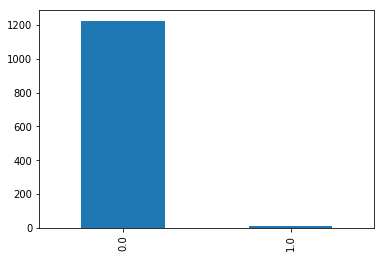

In [47]:
y_pred_xgb = utils.predict_xgb(xgb_model, X_test)
pd.Series(y_pred_xgb.round(0)).value_counts().plot(kind='bar');

              Score
Fscore     0.400000
Precision  0.454545
Recall     0.357143


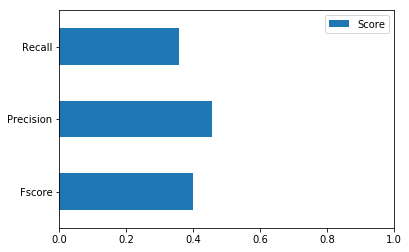

In [48]:
y_pred_round_xgb = [1 if value > 0.5 else 0 for value in y_pred_xgb]
utils.evaluate_performance(y_pred_round_xgb, y_test)

              Score
Fscore     0.322581
Precision  0.294118
Recall     0.357143


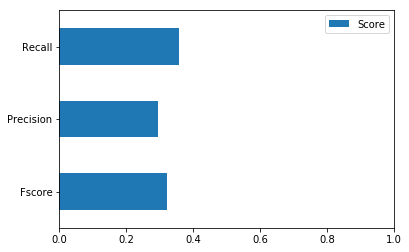

In [49]:
y_pred_round_xgb = [1 if value > 0.2 else 0 for value in y_pred_xgb]
utils.evaluate_performance(y_pred_round_xgb, y_test)

              Score
Fscore     0.486486
Precision  0.391304
Recall     0.642857


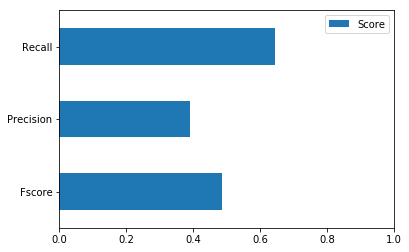

In [50]:
y_pred_round_xgb = [1 if value > 0.1 else 0 for value in y_pred_xgb]
utils.evaluate_performance(y_pred_round_xgb, y_test)

In [51]:
feature_names = X_train.columns.values
ft_importances = utils.feature_importances_xgb(xgb_model, feature_names)
ft_importances

,feature_name,importance
4,initial_deposit_amount,8.0
3,WEEKDAY(ams_first_funded_dts) = unknown,5.0
2,SUM(transactions.trades_sb_stocks_average_leve...,4.0
10,STD(transactions.trades_sb_invested_amount),2.0
7,MONTH(ams_first_funded_dts) = unknown,2.0
9,MEAN(transactions.financing_deposits_amount),1.0
11,SUM(transactions.view_position),1.0
1,SUM(transactions.trades_sb_long),1.0
0,MAX(transactions.trades_sb_long),1.0
8,MAX(transactions.financing_deposits_amount),1.0


Text(0.5,1,'2-class Precision-Recall curve: AP=0.53')

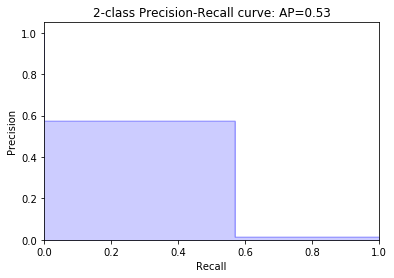

In [52]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, y_pred_xgb)
pr, re, _ = precision_recall_curve(y_test,y_pred,pos_label=1)


plt.step(re, pr, color='b', alpha=0.2,
         where='post')
plt.fill_between(re, pr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## XGBClassifier (another version)

In [53]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions

              Score
Fscore     0.615385
Precision  0.666667
Recall     0.571429


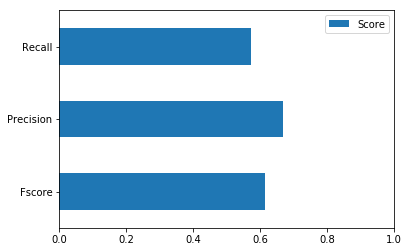

In [54]:
utils.evaluate_performance(predictions, y_test)

In [55]:
# https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/

# CV model
# Ordinary KFold
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, y, cv=kfold, scoring='f1')
print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

F1: 57.55% (17.29%)


In [56]:
# CV model
# StratifiedKFold
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, y, cv=kfold, scoring='f1')
print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

F1: 60.96% (20.04%)


## SMOTE (oversampling)

#### Working with unbalanced classes:

1. Collect more data
2. Use better evaluation metric (AUC, F1, Kappa...)
3. Generate artificial samples of minority class (e.g. SMOTE algorithm)

#### In XGBoost

1. set a small min_child_weight (leaf nodes can have smaller size groups)
2. assign more weights to specific samples while initializing DMatrix
3. control the balance to positive and negative weights using set_post weight parameter
4. use AUC for evaluation

In [57]:
# https://beckernick.github.io/oversampling-modeling/

sm = SMOTE(random_state=100, ratio = 1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/home/jo/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [58]:
pd.Series(y_train_res).value_counts()

1    2840
0    2840
dtype: int64

In [59]:
clf_smote = RandomForestClassifier(n_estimators=25, random_state=12)
clf_smote.fit(X_train_res, y_train_res)
y_pred_smote = clf_smote.predict(X_test)

              Score
Fscore     0.628571
Precision  0.523810
Recall     0.785714


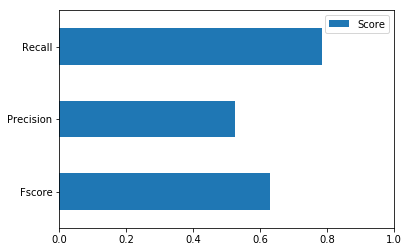

In [60]:
utils.evaluate_performance(y_pred_smote, y_test)

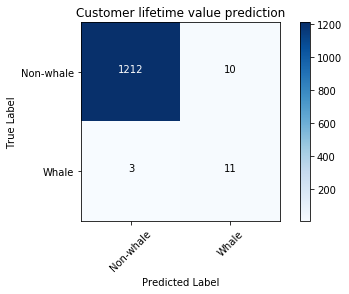

In [61]:
cm = confusion_matrix(y_test, y_pred_smote)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [62]:
# top_features = utils.feature_importances(clf_smote, features_encoded, n=20)
# top_features

### Plot top 5 features

In [ ]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import show

probleem, problem step -> user details

y axis -> feature
x axis -> predicted probability

In [88]:
pd.Series(y_pred_xgb).value_counts()

0.001745    1192
0.091645      14
0.146879       5
0.066296       4
0.290512       3
0.690891       2
0.624159       1
0.218919       1
0.175974       1
0.786062       1
0.710074       1
0.088372       1
0.074940       1
0.556213       1
0.687132       1
0.667127       1
0.039168       1
0.605280       1
0.568188       1
0.328041       1
0.303630       1
0.719059       1
dtype: int64

In [92]:
# hypothesis: the higher the initial deposit, the higher the likelihood that someone will become a whale
# for which users does this not hold? (have a description of the user)
# inspect the users with the highest probability and not classifying correctly


# relevant feature
# fm['initial_deposit']
# X_test[top_feature_string[0]]


# predicted probabilities
# y_pred_xgb

# true values
# y_test

In [165]:
df_temp = pd.DataFrame()

df_temp['feature_value'] = X_test[top_feature_string[0]]
df_temp['predicted_values'] = y_pred_xgb
df_temp['true_value'] = y_test
df_temp.head()

,feature_value,predicted_values,true_value
75,0.0,0.001745,0
50,0.0,0.001745,0
88,0.0,0.001745,0
50,0.0,0.001745,0
96,0.0,0.001745,0


In [173]:
df_temp.sort_values(by='feature_value', ascending=False)[0:15]

,feature_value,predicted_values,true_value
164,1000.0,0.146879,1
130,1000.0,0.786062,1
26,1000.0,0.146879,1
152,1000.0,0.146879,0
223,750.0,0.146879,0
5,200.0,0.710074,1
41,150.0,0.146879,1
161,100.0,0.556213,0
36,100.0,0.719059,1
62,100.0,0.687132,1


In [178]:
output_notebook()

Loading BokehJS ...

In [206]:
len(y_test), len(X_test), len(y_pred_xgb)

(1236, 1236, 1236)

In [226]:
def plot_feature(feature_name):
    colormap = {'0': 'red', '1': 'green'}
    colors = [colormap[x] for x in np.array(y_test.astype(str))]


    p = figure(title = feature_name + " feature relative to predicted probability", plot_width=800, plot_height=400)
    p.xaxis.axis_label = 'Predicted probability'
    p.yaxis.axis_label = feature_name

    p.title.text_font_size = "12pt"
    p.xaxis.axis_label_text_font_size = "10pt"
    p.yaxis.axis_label_text_font_size = "10pt"

    p.circle(np.array(y_pred_xgb), np.array(X_test[feature_name]),
             color=colors, fill_alpha=0.2, size=10)


    show(p)

In [230]:
[plot_feature(feature) for feature in top_feature_string]

ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


[None, None, None, None, None, None, None, None, None, None]

In [213]:
feature_name = top_feature_string[1]


from bokeh.plotting import figure, show
from bokeh.io import output_notebook
# from bokeh.sampledata.iris import flowers

colormap = {'0': 'red', '1': 'green'}
colors = [colormap[x] for x in np.array(y_test.astype(str))]


p = figure(title = feature_name + " feature relative to predicted probability")
p.xaxis.axis_label = 'Predicted probability'
p.yaxis.axis_label = top_feature_string[0]

p.title.text_font_size = '12pt'

p.circle(np.array(y_pred_xgb), np.array(X_test[top_feature_string[0]]),
         color=colors, fill_alpha=0.2, size=10)


show(p)

ERROR:/home/jo/anaconda3/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: b8c01fe7-c4fc-4fe5-be26-359d6cdb47c6


In [214]:
len(X_test[top_feature_string[0]]), len(y_pred_xgb)

(1236, 1236)

In [101]:
fm = fm_encoded

# actual columns
# names = interpretations
col1=top_feature_string[0]
# col2='problem_steps.problems.MEAN(transactions.Duration (sec))'
label=y_test
names=['Title']

In [102]:
colorlist = ['#3A3A3A',  '#1072B9', '#B22222']
colormap = {name: colorlist[name] for name in label}
colormap

{0: '#3A3A3A', 1: '#1072B9'}

In [103]:
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import show

In [117]:
colorlist = ['#3A3A3A',  '#1072B9', '#B22222']
colormap = {name: colorlist[name] for name in label}
colors = [colormap[x] for x in label]
labelmap = {0: 'INCORRECT', 1: 'CORRECT'}
desc = [labelmap[x] for x in label]
source = ColumnDataSource(dict(
    x=pd.Series(X_test[col1]),
    y=pd.Series(y_pred_xgb),
    desc=desc,
    color=colors,
    index=fm.index,
    # problem_step=fm['Step Name'],
    # problem=fm['problem_steps.Problem Name'],
    # attempt=fm['Attempt At Step']
))

In [125]:
fm_encoded.reset_index().index

RangeIndex(start=0, stop=35741, step=1)

In [127]:
dict(
    x=pd.Series(X_test[col1]),
    y=pd.Series(y_pred_xgb),
    desc=desc,
    color=colors,
    index=X_test.reset_index().index,
)

{'color': ['#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '#3A3A3A',
  '

In [128]:
y_pred_xgb

array([ 0.00174544,  0.00174544,  0.00174544, ...,  0.00174544,
        0.66712719,  0.00174544], dtype=float32)

In [129]:
source

In [130]:
%matplotlib inline 

# hover = HoverTool(tooltips=[
# ("(x,y)", "(@x, @y)"),
# ("problem", "@problem"),
# ("problem step", "@problem_step"),
# ])

p = figure(title=names[0])
           # tools=['box_zoom', hover, 'reset'], width=800)
p.scatter(x='x',
          y='y',
          color='color',
          legend='desc',
          source=source,
          alpha=.6)

# p.xaxis.axis_label = names[1]
# p.yaxis.axis_label = names[2]
p

In [66]:
def datashop_plot(fm, col1='', col2='', label=None, names=['', '', '']):
    colorlist = ['#3A3A3A',  '#1072B9', '#B22222']
    colormap = {name: colorlist[name] for name in label}
    colors = [colormap[x] for x in label]
    labelmap = {0: 'INCORRECT', 1: 'CORRECT'}
    desc = [labelmap[x] for x in label]
    source = ColumnDataSource(dict(
        x=fm[col1],
        y=fm[col2],
        desc=desc,
        color=colors,
        index=fm.index,
        problem_step=fm['Step Name'],
        problem=fm['problem_steps.Problem Name'],
        attempt=fm['Attempt At Step']
    ))
    hover = HoverTool(tooltips=[
    ("(x,y)", "(@x, @y)"),
    ("problem", "@problem"),
    ("problem step", "@problem_step"),
    ])
    
    p = figure(title=names[0],
               tools=['box_zoom', hover, 'reset'], width=800)
    p.scatter(x='x',
              y='y',
              color='color',
              legend='desc',
              source=source,
              alpha=.6)

    p.xaxis.axis_label = names[1]
    p.yaxis.axis_label = names[2]
    return p

In [141]:
def datashop_plot(fm, col1='', col2='', label=None, names=['', '', '']):
    colorlist = ['#3A3A3A',  '#1072B9', '#B22222']
    label = y_test
    colormap = {name: colorlist[name] for name in label}
    colors = [colormap[x] for x in label]
    labelmap = {0: 'INCORRECT', 1: 'CORRECT'}
    desc = [labelmap[x] for x in label]
    source = ColumnDataSource(dict(
        x=fm[col1],
        y=fm[col2],
        desc=desc,
        color=colors,
        # index=fm.index,
#         problem_step=fm['Step Name'],
#         problem=fm['problem_steps.Problem Name'],
#         attempt=fm['Attempt At Step']
    ))
#     hover = HoverTool(tooltips=[
#     ("(x,y)", "(@x, @y)"),
#     ("problem", "@problem"),
#     ("problem step", "@problem_step"),
#     ])
    
    p = figure(title=names[0]) # ,
               # tools=['box_zoom', hover, 'reset'], width=800)
    p.scatter(x='x',
              y='y',
              color='color',
              legend='desc',
              source=source,
              alpha=.6)

    p.xaxis.axis_label = names[1]
    p.yaxis.axis_label = names[2]
    return p

'initial_deposit_amount'

In [162]:
datashop_plot(X_test, col1=X_test.columns[0], col2=X_test.columns[1], label=None, names=['This', 'That', 'Yeah'])

In [137]:
fm_encoded[top_feature_string[0]]

user_id
00003ad5-d62d-4a88-ae32-558b9ac70915       0.0
00031f8f-1fa4-4890-9799-e2cb532fdef3       0.0
0006e8e4-d5db-4985-8d37-cdf64d4a72b9       0.0
0006fdaa-91ea-440d-b163-efe8d00e5910       0.0
0007c175-df3c-41d3-b1c3-04f62579e954       0.0
0008f3aa-a581-4c4b-af5c-3101e1ad1ce6       0.0
000959b0-34ad-495e-acef-e24f4c188341       0.0
0009a996-60a0-43c9-9c9b-2ff36c8288e3       0.0
000e9b03-d6f5-4c3e-9b67-59a7f21974d6       0.0
000eed18-177c-4c58-aad8-56f10f9bc5bd       0.0
000ef5d9-de3b-4cfb-9813-8e4618df7a86      50.0
00106c13-f942-4cd7-be89-f218f787d872       0.0
00106f72-d553-4322-8acd-c3aaf83631be       0.0
001148d1-07f8-44a3-bd16-b49279f7cd04       0.0
00144230-26ec-41bf-80af-c1f0dc01d646       0.0
0015eb00-7cbb-4e3a-a1fd-ccac26c08f89       0.0
001aabf1-ec53-44f9-a992-6f37060ff222       0.0
001ce6ed-875b-420c-bfbf-c34cbaeecf82       0.0
001d155d-b913-474e-b743-70174ed0dc0e       0.0
001de8e6-a8c4-4661-8922-e129b0a89068       0.0
00221651-edb4-4654-9d65-c39b75807cf7       0.0
00245